In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

import re
import hashlib
from tensorflow.python.util import compat
import pickle
import random
random.seed(59185)

%matplotlib inline

In [2]:
#https://github.com/adiyoss/GCommandsPytorch/blob/master/gcommand_loader.py
def get_spect(path, window_size=.02, window_stride=.01, window='hamming', normalize = True, max_len=101):
    y, sr = librosa.load(path, sr=None)
    n_fft = int(sr * window_size)
    win_length = n_fft
    hop_length = int(sr * window_stride)

    # STFT
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    spect, _ = librosa.magphase(D)
    # S = log(S+1)
    spect = np.log1p(spect)

    # make all spects with the same dims
    # TODO: change that in the future
    if spect.shape[1] < max_len:
        pad = np.zeros((spect.shape[0], max_len - spect.shape[1]))
        spect = np.hstack((spect, pad))
    elif spect.shape[1] > max_len:
        spect = spect[:max_len, ]
    spect = np.resize(spect, (1, spect.shape[0], spect.shape[1]))
    if normalize:
        mean = spect.mean()
        std = spect.std()
        if std != 0:
            spect = (spect - mean) /std

    return spect

In [3]:
#copy from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/speech_commands/input_data.py#L61
def which_set(filename, validation_percentage, testing_percentage):
  """Determines which data partition the file should belong to.
  We want to keep files in the same training, validation, or testing sets even
  if new ones are added over time. This makes it less likely that testing
  samples will accidentally be reused in training when long runs are restarted
  for example. To keep this stability, a hash of the filename is taken and used
  to determine which set it should belong to. This determination only depends on
  the name and the set proportions, so it won't change as other files are added.
  It's also useful to associate particular files as related (for example words
  spoken by the same person), so anything after '_nohash_' in a filename is
  ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
  'bobby_nohash_1.wav' are always in the same set, for example.
  Args:
    filename: File path of the data sample.
    validation_percentage: How much of the data set to use for validation.
    testing_percentage: How much of the data set to use for testing.
  Returns:
    String, one of 'training', 'validation', or 'testing'.
  """
  base_name = os.path.basename(filename)
  # We want to ignore anything after '_nohash_' in the file name when
  # deciding which set to put a wav in, so the data set creator has a way of
  # grouping wavs that are close variations of each other.
  hash_name = re.sub(r'_nohash_.*$', '', base_name)
  # This looks a bit magical, but we need to decide whether this file should
  # go into the training, testing, or validation sets, and we want to keep
  # existing files in the same set even if more files are subsequently
  # added.
  # To do that, we need a stable way of deciding based on just the file name
  # itself, so we do a hash of that and then use that to generate a
  # probability value that we use to assign it.
  hash_name_hashed = hashlib.sha1(compat.as_bytes(hash_name)).hexdigest()
  MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M
  percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_WAVS_PER_CLASS + 1)) *
                     (100.0 / MAX_NUM_WAVS_PER_CLASS))
  if percentage_hash < validation_percentage:
    result = 'validation'
  elif percentage_hash < (testing_percentage + validation_percentage):
    result = 'testing'
  else:
    result = 'training'
  return result

In [9]:
def save_feature(all_data , feature_name , save_dir):
    condition = True
    version = 0
    while (condition):
        version += 1
        save_file = feature_name + "_v" + str(version) + ".pkl"
        condition = save_file in os.listdir(save_dir)
        
    
    with open(save_dir + save_file, 'wb') as fp:
        pickle.dump(all_data, fp)
    print("saved file is: " + save_dir + save_file)

In [51]:
train_audio_path = '/home/maikfangogoair/tmp/label_data/'
word_list = [x for x in os.listdir(train_audio_path) if os.path.isdir(train_audio_path + x) and x != '_background_noise_']
wanted_list = word_list

30

In [6]:
validation_percentage = 10
testing_percentage = 10
unknown_percentage = 5
all_data = []
feature_name = "spect"
feature_func = {"spect": get_spect}[feature_name]

for label in word_list:
    for filename in os.listdir(train_audio_path + label):
        if filename.endswith('.wav') or filename.endswith('.WAV'):
            if label in wanted_list:
                label_idx = wanted_list.index(label)
            elif random.randint(1,100) <= unknown_percentage:
                label_idx = wanted_list.index("unknown")
            else:
                continue
            feature = feature_func(train_audio_path + label + "/" + filename)
            all_data.append({"label":label, "label_idx": label_idx, "filename": filename, \
                                 "speaker": filename.split('_')[0],\
                                 "feature": feature, \
                                 "group": which_set(filename, validation_percentage, testing_percentage)})

random.shuffle(all_data)
save_dir = "/home/maikfangogoair/tmp/save/"
save_feature(all_data , feature_name , save_dir)


In [ ]:
data_statistics = {"validation":{},"testing":{},"training":{}}
for x in all_data:
    data_statistics[x["group"]][x["label"]] = data_statistics[x["group"]].get(x["label"],0) + 1
data_statistics

In [12]:
#check if any speaker in different group?
speaker_list = {}
for x in all_data:
    l = speaker_list.get(x["speaker"], {})
    if x["group"] in l.keys():
        speaker_list[x["speaker"]][x["group"]] += 1
    else:
        l[x["group"]] = 1
        speaker_list[x["speaker"]] = l
print("There are %d different speakers." % len(speaker_list))
print("There are %d speakers have more than one group." % len([{k,v} for k,v in speaker_list.items() if len(v.items()) > 1]))
#check sum
summary = 0
for _, v in speaker_list.items():
    summary = summary + v.get("training",0) + v.get("testing",0) +v.get("validation",0)
assert summary == len(all_data)
print("Total wave count is: %d." %  summary  )

There are 1881 different speakers.
There are 0 speakers have more than one group.
Total wave count is: 64721.


In [40]:
def show_spec(one_line):
    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    ax1.imshow(np.squeeze(one_line["feature"], axis=0) , aspect='auto', origin='lower')
    ax1.set_title(one_line["label"])

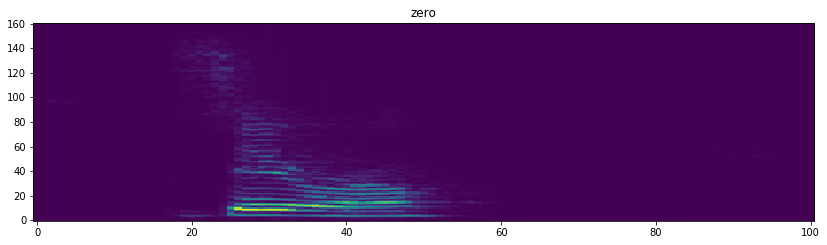

In [50]:
one_line = all_data[random.randint(0,64721)]
show_spec(one_line)
ipd.Audio(join(train_audio_path, one_line["label"]+"/"+one_line["filename"]))